##Mini Projet IA Avancé
Elaboré par:<br>
Barouni Abir &
Zaoui Eya &
Beyrem Malek &
Sejil Nouha <br>
<br>
**3 IDL 02**



In [1]:
import tensorflow as tf

# Vérifier si un GPU est disponible
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Afficher les détails du GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print(f"GPU found: {gpu}")
else:
    print("No GPU found, falling back to CPU.")

Num GPUs Available:  1
GPU found: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Forcer TensorFlow à utiliser le GPU
tf.config.set_visible_devices(gpu_devices[0], 'GPU')

In [3]:
!unzip DataSet.zip -d /content

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/DataSet/train/labels/00000_00004_00005_png.rf.55e0ec09c7c892e631d9197011a8ad27.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00006_png.rf.da366faadf7731d50e66efd84b21603d.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00007_png.rf.f744cfc8a356e487f01a3bb8a4811faf.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00008_png.rf.a1b3fa49377e1b891a672b08c3b9dd46.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00009_png.rf.6a03d806047caed49e6cb42e9d38b1c5.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00009_png.rf.a42aea6ddf4fbbe97895c91fc7a803bf.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00010_png.rf.10933ed7cc67a259b214117c6e134a35.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00011_png.rf.2a4d495dca500a33034661bfb2be18f0.txt  
  inflating: /content/DataSet/train/labels/00000_00004_00011_png.r

In [5]:
import os
import shutil

# Base directories
base_dirs = ['DataSet/train', 'DataSet/valid', 'DataSet/test']
output_dirs = ['ProcessedData/train', 'ProcessedData/valid', 'ProcessedData/test']

# Liste des classes
classes = [
    "Green Light", "Red Light", "Speed Limit 10", "Speed Limit 100", "Speed Limit 110",
    "Speed Limit 120", "Speed Limit 20", "Speed Limit 30", "Speed Limit 40", "Speed Limit 50",
    "Speed Limit 60", "Speed Limit 70", "Speed Limit 80", "Speed Limit 90", "Stop"
]

# Fonction pour copier les données
def process_directory(base_dir, output_dir):
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')

    # Créer les répertoires pour chaque classe
    for class_name in classes:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

    # Parcourir les fichiers d'annotations
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            image_name = label_file.replace('.txt', '.jpg')  # Supposez les images en .jpg
            image_path = os.path.join(images_dir, image_name)

            if not os.path.exists(image_path):  # Vérifier si l'image existe
                print(f"Image non trouvée pour {label_file}, ignorée.")
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = int(line.split()[0])  # ID de la classe
                    class_name = classes[class_id]

                    # Copier l'image dans le répertoire correspondant
                    dest_dir = os.path.join(output_dir, class_name)
                    shutil.copy(image_path, dest_dir)

# Traiter chaque répertoire (train, valid, test)
for base_dir, output_dir in zip(base_dirs, output_dirs):
    print(f"Traitement du répertoire : {base_dir}")
    process_directory(base_dir, output_dir)


Traitement du répertoire : DataSet/train
Traitement du répertoire : DataSet/valid
Traitement du répertoire : DataSet/test


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_transfer_model(input_shape, num_classes):
    # Load pre-trained MobileNetV2 model without the top layer (for fine-tuning)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last few layers for fine-tuning
    base_model.trainable = True
    # Optionally, unfreeze specific layers (e.g., the last 4 layers):
    # base_model.layers[-4:].trainable = True

    # Add custom layers on top of the pre-trained model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling layer
    x = Dense(128, activation='relu')(x)  # Dense layer
    x = Dropout(0.5)(x)  # Dropout layer for regularization
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling for validation and test data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    'ProcessedData/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_gen = val_datagen.flow_from_directory(
    'ProcessedData/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)



Found 3944 images belonging to 15 classes.
Found 867 images belonging to 15 classes.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop if the validation loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore the best weights when training stops
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.2,  # Reduce the learning rate by a factor of 2
    patience=3,  # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-6  # Minimum learning rate
)


In [9]:
input_shape = (224, 224, 3)
num_classes = len(train_gen.class_indices)  # Number of classes in the dataset

# Create the model
model = create_transfer_model(input_shape, num_classes)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # Train for 30 epochs (you can adjust this)
    callbacks=[early_stopping, reduce_lr]  # Add early stopping and learning rate scheduler
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 130s 632ms/step - accuracy: 0.1919 - loss: 2.6118 - val_accuracy: 0.3172 - val_loss: 2.0529 - learning_rate: 1.0000e-04
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 53s 403ms/step - accuracy: 0.3972 - loss: 1.8430 - val_accuracy: 0.3875 - val_loss: 1.8561 - learning_rate: 1.0000e-04
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - accuracy: 0.5111 - loss: 1.4422 - val_accuracy: 0.4314 - val_loss: 1.6568 - learning_rate: 1.0000e-04
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.6180 - loss: 1.1300 - val_accuracy: 0.5755 - val_loss: 1.3383 - learning_rate: 1.0000e-04
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 53s 412ms/step - accuracy: 0.6563 - loss: 1.0087 - val_accuracy: 0.6125 - val_loss: 1.1894 - learning_rate: 1.0000e-04
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 406ms/step - accuracy: 0.7057 - loss: 0.8456 - val_accuracy: 0.6367 - val_loss: 1.1475 - learning_rate: 1.0000e-04
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 53s 408ms/step -

In [10]:
# Test data generator
test_gen = val_datagen.flow_from_directory(
    'ProcessedData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Don't shuffle so predictions align with ground truth
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}")



Found 700 images belonging to 15 classes.
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.8134 - loss: 0.5392
Test Accuracy: 0.81


In [11]:
model.save('road_violation_model3.keras')

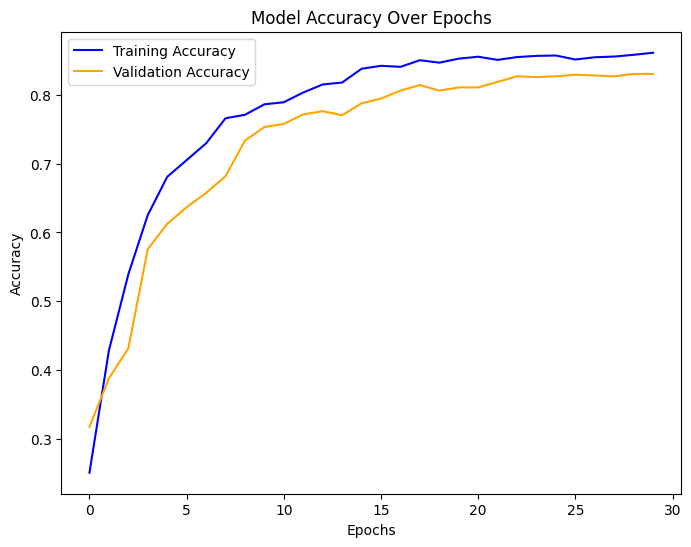

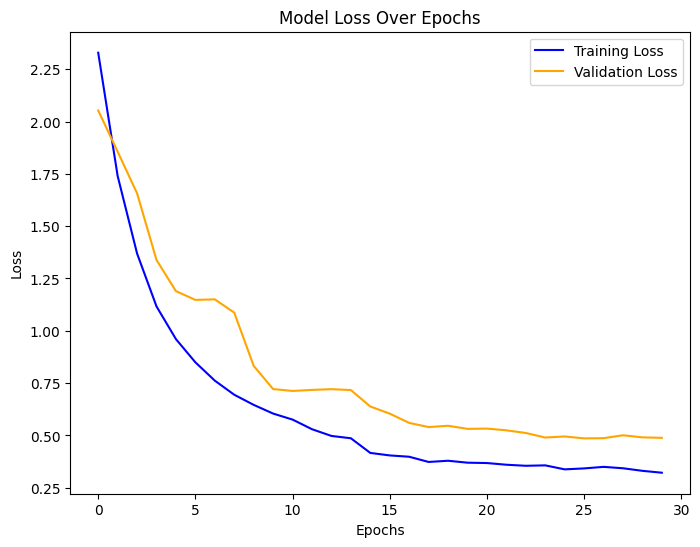

In [13]:
import matplotlib.pyplot as plt

# Plot training vs. validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training vs. validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 700 images belonging to 15 classes.
 1/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9688 - loss: 0.1640

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8134 - loss: 0.5392
Test Accuracy: 0.81
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


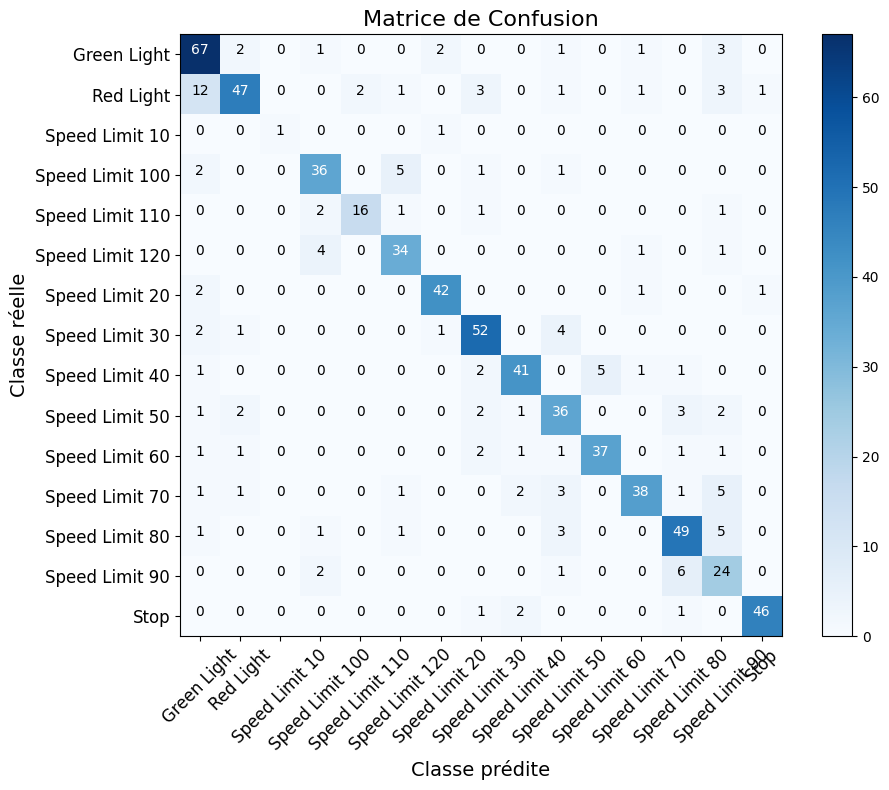

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur spécifique pour le test
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateur de données de test
test_gen = test_datagen.flow_from_directory(
    'ProcessedData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Évaluer le modèle sur les données de test
test_steps = np.ceil(test_gen.samples / test_gen.batch_size).astype(int)
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Effectuer les prédictions
y_pred = model.predict(test_gen, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matrice de Confusion", fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    # Ajouter les valeurs dans les cellules
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Classe réelle", fontsize=14)
    plt.xlabel("Classe prédite", fontsize=14)
    plt.tight_layout()
    plt.show()

# Afficher la matrice de confusion
plot_confusion_matrix(y_true, y_pred_classes, test_gen.class_indices.keys())


**TEST**

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [24]:
# Define the prediction function
def predict_image(image_path, model, class_names):
    """
    Predict the classes for a single image.

    Args:
    - image_path: Path to the test image.
    - model: The trained multi-label classification model.
    - class_names: List of class names corresponding to the output vector.

    Returns:
    - predicted_classes: List of classes detected in the image.
    - probabilities: Probability scores for each class.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))  # Resize to match model input size
    image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Predict
    probabilities = model.predict(image_array)[0]  # Get predictions for the first (and only) image in the batch
    predicted_classes = [class_names[i] for i, prob in enumerate(probabilities) if prob > 0.5]  # Threshold = 0.5

    return predicted_classes, probabilities


In [25]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/road_violation_model3.keras'  # Path to the saved model file
model = load_model(model_path)


In [26]:
class_names = ["Green Light", "Red Light", "Speed Limit 10", "Speed Limit 100", "Speed Limit 110",
               "Speed Limit 120", "Speed Limit 20", "Speed Limit 30", "Speed Limit 40", "Speed Limit 50",
               "Speed Limit 60", "Speed Limit 70", "Speed Limit 80", "Speed Limit 90", "Stop"]


In [27]:
# Path to a test image
test_image_path = '/content/road822_png.rf.b3ba7f5457042a083bad8aac3fe5f819.jpg'

# Predict the classes for the test image
predicted_classes, probabilities = predict_image(test_image_path, model, class_names)

# Print the results
print(f"Predicted Classes: {predicted_classes}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"{class_names[i]}: {prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Classes: ['Stop']
Class Probabilities:
Green Light: 0.00
Red Light: 0.04
Speed Limit 10: 0.00
Speed Limit 100: 0.00
Speed Limit 110: 0.00
Speed Limit 120: 0.00
Speed Limit 20: 0.00
Speed Limit 30: 0.00
Speed Limit 40: 0.00
Speed Limit 50: 0.00
Speed Limit 60: 0.00
Speed Limit 70: 0.00
Speed Limit 80: 0.00
Speed Limit 90: 0.00
Stop: 0.96
